# Part 1: Data Processing & Feature Engineering


## 1.1 Setup, Imports & Configuration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import warnings
import gc

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
plt.style.use('seaborn-v0_8-whitegrid') 
%matplotlib inline 

# --- Configuration for THIS NOTEBOOK ---
DATA_BASE_PATH = './data/' # Path to main Zillow data files
DICT_PATH = os.path.join(DATA_BASE_PATH, 'Dictionary/') # Corrected path for dictionary files
MODEL_DIR = 'saved_models'
STATIC_FOLDER = 'static'
PLOTS_SUBFOLDER = 'plots'
PLOTS_DIR = os.path.join(STATIC_FOLDER, PLOTS_SUBFOLDER)
MISSING_THRESHOLD = 50.0
CLEANED_DATA_CSV_PATH = './data/df_cleaned_for_modeling.csv'
CLEANED_DATA_ARTIFACTS_PATH = os.path.join(MODEL_DIR, 'data_processing_artifacts.joblib') # Corrected path

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(os.path.dirname(CLEANED_DATA_CSV_PATH), exist_ok=True)
os.makedirs(DICT_PATH, exist_ok=True) # Ensure dict path exists 

print(f"Part 1 Setup: DATA_BASE_PATH='{DATA_BASE_PATH}', DICT_PATH='{DICT_PATH}'")

Part 1 Setup: DATA_BASE_PATH='./data/', DICT_PATH='./data/Dictionary/'


## 1.2 Load Dictionaries

In [3]:
def load_main_dictionary(filepath, field_col='Feature', desc_col='Description'):
    print(f"Loading main dict: {filepath}")
    try: df_dict=pd.read_csv(filepath)
    except FileNotFoundError: print(f"ERROR: File not found: {filepath}"); return {}
    if field_col not in df_dict.columns or desc_col not in df_dict.columns:
        if len(df_dict.columns)>=2: field_col,desc_col=df_dict.columns[0],df_dict.columns[1];print(f"Warn: Using fallback cols: {field_col},{desc_col}")
        else: print("Err: Cannot find dict cols"); return {}
    df_dict.dropna(subset=[field_col],inplace=True); df_dict[desc_col].fillna('No desc',inplace=True)
    if pd.api.types.is_string_dtype(df_dict[field_col]): df_dict[field_col]=df_dict[field_col].str.strip("'\" ")
    descs=pd.Series(df_dict[desc_col].values, index=df_dict[field_col].str.lower()).to_dict(); print(f"Loaded {len(descs)} descriptions."); return descs

def load_id_value_map(filepath, key_col_header, value_col_pattern='desc'):
    print(f"Loading ID map: {os.path.basename(filepath)} for '{key_col_header}'")
    try: df_map=pd.read_csv(filepath)
    except FileNotFoundError: print(f"Warn: File not found: {filepath}"); return None
    key_col=next((c for c in df_map.columns if c.lower()==key_col_header.lower()),None)
    if not key_col: print(f"Warn: Key '{key_col_header}' not in {os.path.basename(filepath)}"); return None
    val_col=next((c for c in df_map.columns if value_col_pattern.lower() in c.lower() and c.lower()!=key_col.lower()),df_map.columns[1] if len(df_map.columns)>=2 and df_map.columns[1].lower()!=key_col.lower() else None)
    if val_col: df_map.dropna(subset=[key_col],inplace=True);df_map[val_col].fillna('Unknown',inplace=True);df_map[key_col]=pd.to_numeric(df_map[key_col],errors='coerce');df_map.dropna(subset=[key_col],inplace=True);mapping=pd.Series(df_map[val_col].values,index=df_map[key_col]).to_dict();print(f" -> Loaded {len(mapping)} entries.");return mapping
    else: print(f"Warn: Value col not found for '{key_col}'."); return None

assert 'DICT_PATH' in locals(), "DICT_PATH not defined. Run previous cell!"
main_dict_path = os.path.join(DICT_PATH, 'Data_Dictionary.csv')
field_descriptions = load_main_dictionary(main_dict_path)
id_map_filenames={'airconditioningtypeid':'AirConditioningTypeID.csv','architecturalstyletypeid':'ArchitecturalStyleTypeID.csv','buildingclasstypeid':'BuildingClassTypeID.csv','heatingorsystemtypeid':'HeatingOrSystemTypeID.csv','propertylandusetypeid':'PropertyLandUseTypeID.csv','storytypeid':'StoryTypeID.csv','typeconstructiontypeid':'TypeConstructionTypeID.csv'}
id_value_mappings={}
for df_key,fname in id_map_filenames.items():
    mapping=load_id_value_map(os.path.join(DICT_PATH,fname),fname.replace('.csv',''),'desc')
    if mapping: id_value_mappings[df_key]=mapping
print("Dictionaries loaded.")

Loading main dict: ./data/Dictionary/Data_Dictionary.csv
Loaded 58 descriptions.
Loading ID map: AirConditioningTypeID.csv for 'AirConditioningTypeID'
 -> Loaded 13 entries.
Loading ID map: ArchitecturalStyleTypeID.csv for 'ArchitecturalStyleTypeID'
 -> Loaded 27 entries.
Loading ID map: BuildingClassTypeID.csv for 'BuildingClassTypeID'
 -> Loaded 5 entries.
Loading ID map: HeatingOrSystemTypeID.csv for 'HeatingOrSystemTypeID'
 -> Loaded 25 entries.
Loading ID map: PropertyLandUseTypeID.csv for 'PropertyLandUseTypeID'
 -> Loaded 25 entries.
Loading ID map: StoryTypeID.csv for 'StoryTypeID'
 -> Loaded 35 entries.
Loading ID map: TypeConstructionTypeID.csv for 'TypeConstructionTypeID'
 -> Loaded 18 entries.
Dictionaries loaded.


## 1.3 Load & Merge Main Data

In [4]:
print("--- Loading and Merging Main Data ---")
assert 'DATA_BASE_PATH' in locals(), "DATA_BASE_PATH not defined. Run config cell!"
try:
    props_2016 = pd.read_csv(os.path.join(DATA_BASE_PATH, 'properties_2016.csv'), low_memory=False)
    train_2016 = pd.read_csv(os.path.join(DATA_BASE_PATH, 'train_2016.csv'), parse_dates=['transactiondate'])
    props_2017 = pd.read_csv(os.path.join(DATA_BASE_PATH, 'properties_2017.csv'), low_memory=False)
    train_2017 = pd.read_csv(os.path.join(DATA_BASE_PATH, 'train_2017.csv'), parse_dates=['transactiondate'])
except FileNotFoundError as e: print(f"ERROR: Data file missing: {e}"); raise e
train_2016['year'] = 2016; train_2017['year'] = 2017
df_2016 = train_2016.merge(props_2016, how='left', on='parcelid')
df_2017 = train_2017.merge(props_2017, how='left', on='parcelid')
df = pd.concat([df_2016, df_2017], ignore_index=True); df.columns = df.columns.str.lower()
print(f"Initial merged data shape: {df.shape}"); display(df.head(2))
del props_2016, props_2017, train_2016, train_2017, df_2016, df_2017; gc.collect()

--- Loading and Merging Main Data ---
Initial merged data shape: (167888, 61)


,parcelid,logerror,transactiondate,year,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,2016,1.0,NaN,NaN,2.0,3.0,NaN,4.0,2.0,NaN,NaN,1684.0,1684.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,34280990.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,LARS,6.037107e+07,12447.0,3101.0,31817.0,96370.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1959.0,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,2016,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,2263.0,2263.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,468.0,NaN,NaN,33668120.0,-117677556.0,3643.0,NaN,NaN,NaN,NaN,NaN,1,261.0,NaN,6.059052e+07,32380.0,1286.0,NaN,96962.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,2014.0,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN


4

## 1.4 Feature Engineering & Transformations

In [5]:
print("--- Feature Engineering & Transformations ---")
for col,id_map in id_value_mappings.items():
    if col in df.columns: df[col]=pd.to_numeric(df[col],errors='coerce').map(id_map).fillna('Unknown')

if 'regionidzip' in df.columns:
    df['regionidzip']=df['regionidzip'].astype(str).fillna('Unknown_ZIP')
    df['regionidzip']=df['regionidzip'].apply(lambda x: str(int(float(x))) if '.' in str(x) and str(x).replace('.','',1).isdigit() else str(x))
print("ID translations applied. 'regionidzip' converted to cleaned string, will be further processed for model input.")

assert 'taxvaluedollarcnt' in df.columns and 'logerror' in df.columns, "Tax/logerror missing!"
df['taxvaluedollarcnt']=pd.to_numeric(df['taxvaluedollarcnt'],errors='coerce'); df.dropna(subset=['taxvaluedollarcnt','logerror'],inplace=True); df=df[df['taxvaluedollarcnt']>0]
df['log_zest']=np.log(df['taxvaluedollarcnt']); df['log_sp']=df['log_zest']-df['logerror']; df['saleprice']=np.exp(df['log_sp'])
df.drop(columns=['logerror','log_zest','log_sp','transactiondate','taxvaluedollarcnt'],errors='ignore',inplace=True)
df=df[~df['saleprice'].isin([np.inf,-np.inf])].dropna(subset=['saleprice']); print(f"Shape after SalePrice: {df.shape}")

if 'yearbuilt' in df.columns and 'year' in df.columns:
    df['yearbuilt']=pd.to_numeric(df['yearbuilt'],errors='coerce'); df['year']=pd.to_numeric(df['year'],errors='coerce')
    df['building_age']=df['year']-df['yearbuilt']; df['building_age']=df['building_age'].clip(lower=0,upper=200)
    print("Created 'building_age'.")
display(df[['year','building_age','saleprice','regionidzip', 'fips'] + [k for k in id_value_mappings.keys() if k in df.columns][:1]].head(3))

--- Feature Engineering & Transformations ---
ID translations applied. 'regionidzip' converted to cleaned string, will be further processed for model input.
Shape after SalePrice: (167852, 59)
Created 'building_age'.


,year,building_age,saleprice,regionidzip,fips,airconditioningtypeid
0,2016,57.0,350365.236140,96370,6037.0,Central
1,2016,2.0,692920.803591,96962,6059.0,Unknown
2,2016,76.0,120386.584528,96293,6037.0,Central


## 1.5 Data Cleaning (Missing Values, Column Drops, Outliers)

--- Data Cleaning ---


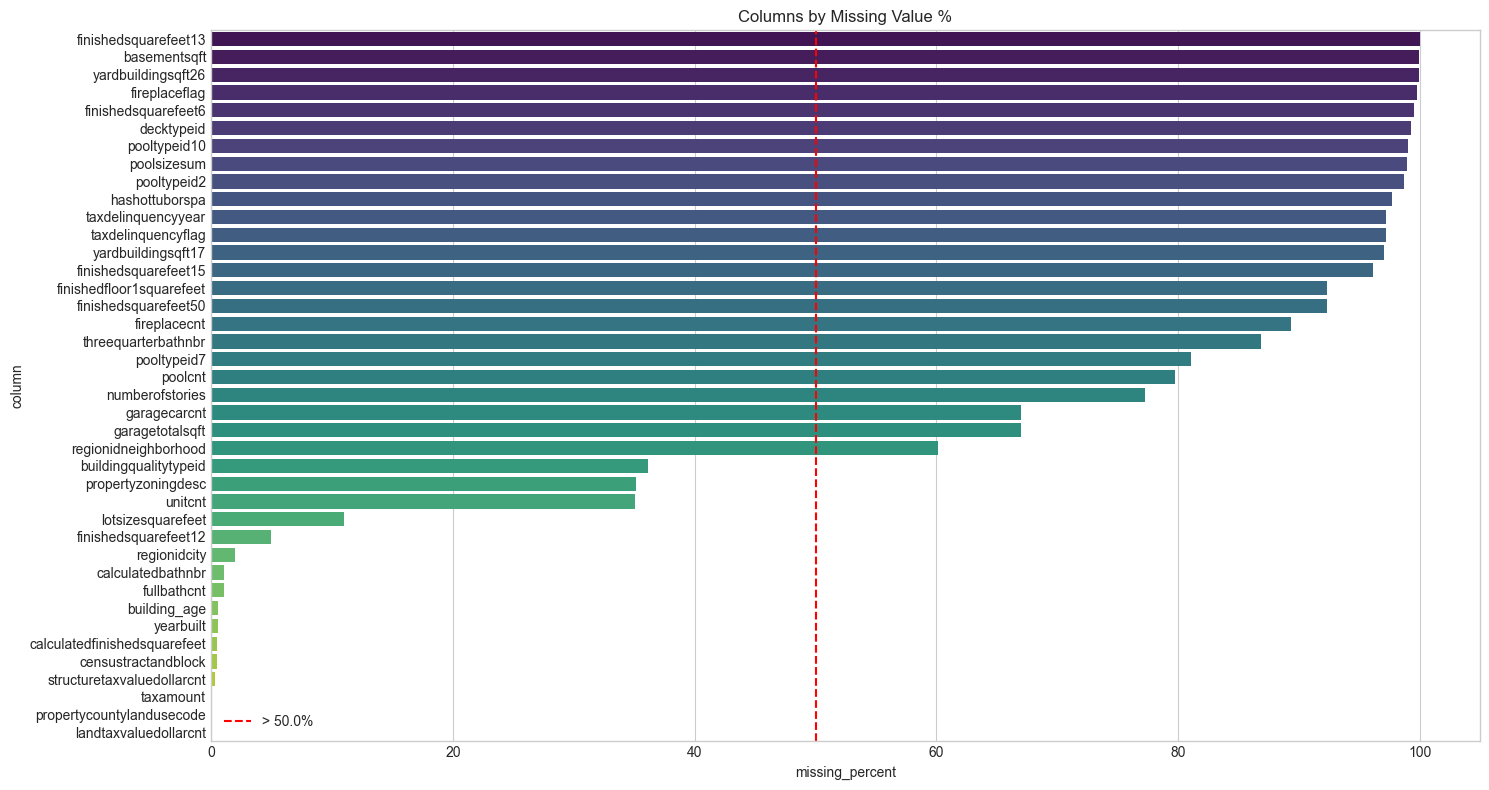

- Missing value plot saved.
Dropped 38 cols. Kept 22.
Column status plot saved: static\plots\column_status_counts.png


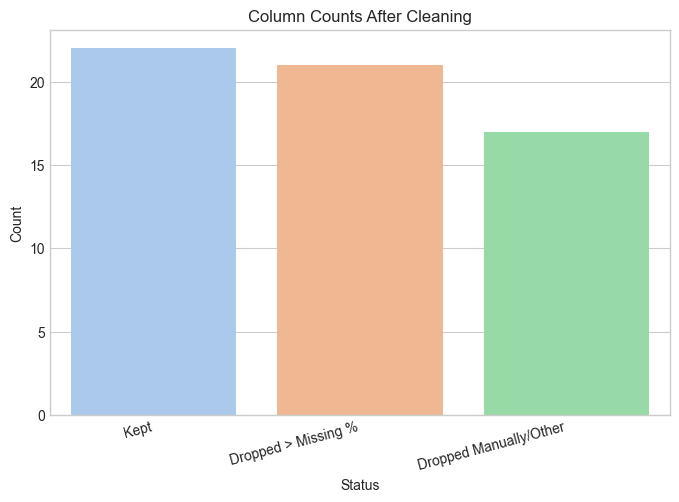

Shape after outlier handling: (161247, 22)
MODEL Numerical Feats (for Preprocessor) (11): ['bathroomcnt', 'bedroomcnt', 'building_age', 'buildingqualitytypeid', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fullbathcnt', 'lotsizesquarefeet', 'roomcnt', 'unitcnt']
MODEL Categorical Feats (for Preprocessor) (10): ['airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid', 'fips', 'heatingorsystemtypeid', 'propertylandusetypeid', 'regionidzip', 'storytypeid', 'typeconstructiontypeid', 'year']


In [6]:
print("--- Data Cleaning ---")
initial_cols_count = len(df.columns)

# 1.5.1 Visualize Missing Values
missing_vals = df.isnull().sum(); missing_percent = (missing_vals/len(df))*100
missing_df = pd.DataFrame({'column':df.columns,'missing_percent':missing_percent}).sort_values('missing_percent', ascending=False)
missing_df_plot = missing_df[missing_df['missing_percent'] > 0]
if not missing_df_plot.empty:
    plt.figure(figsize=(15, max(6, len(missing_df_plot)*0.2)))
    sns.barplot(x='missing_percent', y='column', data=missing_df_plot, palette='viridis')
    plt.axvline(x=MISSING_THRESHOLD, color='r', linestyle='--', label=f'> {MISSING_THRESHOLD}%')
    plt.title(f'Columns by Missing Value %')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR,'missing_values.png'))
    plt.show()
    plt.close()
    print("- Missing value plot saved.")
else:
    print("- No columns with missing values to plot.")

# 1.5.2 Define Columns to Drop
cols_to_drop_missing = missing_df[missing_df['missing_percent']>MISSING_THRESHOLD].index.tolist()
cols_to_drop_manual = [
    # Identifiers / High Cardinality Text
    'parcelid',
    'propertyzoningdesc',          # Text description, often sparse/complex
    'propertycountylandusecode', # Specific code, landusetypeid is broader

    # Location identifiers (keep regionidzip as a feature)
    'regionidcity',
    'regionidcounty',
    'regionidneighborhood',
    # 'regionidzip', # KEEPING THIS ONE

    # Census info (often redundant or too granular)
    'rawcensustractandblock',
    'censustractandblock',

    # Tax related fields (potential leakage or redundant info)
    'assessmentyear',
    'structuretaxvaluedollarcnt', # Part of taxvaluedollarcnt
    'taxvaluedollarcnt',          # Used to DERIVE target, potential leakage if kept
    'landtaxvaluedollarcnt',      # Part of taxvaluedollarcnt
    'taxamount',                  # Highly correlated with value, potential leakage

    # Tax delinquency (sparse and might not generalize well)
    'taxdelinquencyflag',
    'taxdelinquencyyear',

    # Redundant Lat/Lon if keeping FIPS/ZIP? (Keep for now, potentially useful)
    'yearbuilt',
    'latitude',
    'longitude'
    ]
cols_to_drop_manual = [c for c in cols_to_drop_manual if c in df.columns]
all_cols_to_drop = list(set(cols_to_drop_missing + cols_to_drop_manual))
protected_cols = ['saleprice','year','building_age','regionidzip', 'fips'] # 'regionidzip' and 'fips' are now protected as they are intended model inputs
final_cols_to_drop = [c for c in all_cols_to_drop if c not in protected_cols]
df_cleaned = df.drop(columns=final_cols_to_drop, errors='ignore'); 
kept_columns_count_final = len(df_cleaned.columns)
print(f"Dropped {len(final_cols_to_drop)} cols. Kept {len(df_cleaned.columns)}.")
del df; gc.collect()

plot_counts_df = pd.DataFrame({
    'Status': ['Kept', 'Dropped > Missing %', 'Dropped Manually/Other'],
    'Count': [kept_columns_count_final, 
              len(set(cols_to_drop_missing) - set(cols_to_drop_manual)),
              len(set(all_cols_to_drop) - (set(cols_to_drop_missing) - set(cols_to_drop_manual)) )]
})
plt.figure(figsize=(8,5)); sns.barplot(x='Status', y='Count', data=plot_counts_df, palette='pastel')
plt.title('Column Counts After Cleaning')
plt.xticks(rotation=15, ha='right')
col_status_plot_path = os.path.join(PLOTS_DIR, 'column_status_counts.png')
try: 
    plt.savefig(col_status_plot_path)
    print(f"Column status plot saved: {col_status_plot_path}")
except Exception as e: print(f"Error saving column status plot: {e}")
plt.show(); plt.close()

# Outlier Handling
if 'saleprice' in df_cleaned.columns:
    price_cap=df_cleaned['saleprice'].quantile(0.99);price_floor=df_cleaned['saleprice'].quantile(0.01);df_cleaned=df_cleaned[(df_cleaned['saleprice']>=price_floor)&(df_cleaned['saleprice']<=price_cap)]
if 'calculatedfinishedsquarefeet' in df_cleaned.columns:
    sqft_cap=df_cleaned['calculatedfinishedsquarefeet'].quantile(0.99)
    sqft_floor=df_cleaned['calculatedfinishedsquarefeet'].quantile(0.01)
    df_cleaned=df_cleaned[(df_cleaned['calculatedfinishedsquarefeet'].isnull())|((df_cleaned['calculatedfinishedsquarefeet']>=sqft_floor)&(df_cleaned['calculatedfinishedsquarefeet']<=sqft_cap)&(df_cleaned['calculatedfinishedsquarefeet']>0))]
print(f"Shape after outlier handling: {df_cleaned.shape}")

# Define MODEL Feature Types (for the preprocessor in Part 2)
numeric_features = df_cleaned.select_dtypes(include=np.number).drop(columns=['saleprice'],errors='ignore').columns.tolist()
if 'building_age' in df_cleaned.columns and 'building_age' not in numeric_features and pd.api.types.is_numeric_dtype(df_cleaned['building_age']): 
    numeric_features.append('building_age')

categorical_features = df_cleaned.select_dtypes(include=['object']).columns.tolist()

# Ensure 'regionidzip', 'fips', and 'year' are treated as categorical for the model preprocessor
cols_to_force_categorical = ['regionidzip', 'year', 'fips'] 
for col_fc in cols_to_force_categorical:
    if col_fc in df_cleaned.columns:
        if col_fc in numeric_features: # If it was misclassified as numeric (e.g. fips or year before casting)
            numeric_features.remove(col_fc)
        if col_fc not in categorical_features: # Add to categorical if not already (e.g. if it was object)
            categorical_features.append(col_fc)
        # Ensure correct dtype for preprocessor if not already string/object
        if df_cleaned[col_fc].dtype != 'object' and df_cleaned[col_fc].dtype != pd.StringDtype(): 
            df_cleaned[col_fc] = df_cleaned[col_fc].astype(str)

bool_like_model=['fireplaceflag','hashottuborspa']
for b in bool_like_model:
    if b in df_cleaned.columns:
        if b in numeric_features: numeric_features.remove(b)
        if b not in categorical_features: categorical_features.append(b)
        if df_cleaned[b].dtype != 'object' and df_cleaned[b].dtype != pd.StringDtype(): 
            df_cleaned[b] = df_cleaned[b].astype(str)

numeric_features=[c for c in numeric_features if c in df_cleaned.columns and c!='saleprice']
categorical_features=[c for c in categorical_features if c in df_cleaned.columns and c!='saleprice']
print(f"MODEL Numerical Feats (for Preprocessor) ({len(numeric_features)}): {sorted(numeric_features)}")
print(f"MODEL Categorical Feats (for Preprocessor) ({len(categorical_features)}): {sorted(categorical_features)}")
assert 'regionidzip' in categorical_features, "'regionidzip' MUST be in categorical_features for the model!"
assert 'fips' in categorical_features, "'fips' MUST be in categorical_features for the model!"

## 1.6 Extract Unique ZIPs & Default Suggestions from `df_cleaned`

In [6]:
print("--- Extracting Zips and Default Suggestions ---")
available_zips_clean = []
if 'regionidzip' in df_cleaned.columns: 
    try: 
        zips_s = df_cleaned['regionidzip'].dropna().astype(str)
        available_zips_clean = sorted(list(zips_s.unique()))
        print(f"Found {len(available_zips_clean)} unique region ZIP codes from 'df_cleaned' for UI dropdown.")
    except Exception as e_zip: print(f"Warn: ZIP processing error: {e_zip}")
else: print("Warning: 'regionidzip' not in df_cleaned.")

available_fips_clean = []
if 'fips' in df_cleaned.columns:
    if 'fips' in categorical_features: # Check if it's a model input
        try:
            fips_s = df_cleaned['fips'].dropna().astype(str) 
            available_fips_clean = sorted(list(fips_s.unique()))
            print(f"Found {len(available_fips_clean)} unique FIPS codes from 'df_cleaned' for UI dropdown.")
        except Exception as e_fips: print(f"Warn: FIPS processing error: {e_fips}")
    else: print("Info: 'fips' is in df_cleaned but not in 'categorical_features' for model. Skipping FIPS dropdown value extraction.")
else: print("Warning: 'fips' column not found in df_cleaned.")

default_suggestions = {}
for col in numeric_features: 
    if col in df_cleaned.columns:
        median_val = df_cleaned[col].dropna().median()
        if pd.notnull(median_val): default_suggestions[col] = int(median_val) if median_val==np.floor(median_val) else round(median_val, 2)
for col in ['regionidzip', 'fips']:
    if col in categorical_features and col in df_cleaned.columns: 
        if col not in default_suggestions: # Avoid overwriting if somehow already set
            try:
                mode_val = df_cleaned[col].mode()
                if not mode_val.empty: default_suggestions[col] = mode_val[0]
                else: default_suggestions[col] = "Unknown" # Fallback
            except Exception: default_suggestions[col] = "Unknown"
print(f"Generated {len(default_suggestions)} default suggestions for model features.")

expected_columns_for_model = [col for col in df_cleaned.columns if col != 'saleprice']
print(f"Total expected columns in 'df_cleaned' (excluding target, for X input to preprocessor): {len(expected_columns_for_model)}")

--- Extracting Zips and Default Suggestions ---
Found 391 unique region ZIP codes from 'df_cleaned' for UI dropdown.
Found 3 unique FIPS codes from 'df_cleaned' for UI dropdown.
Generated 13 default suggestions for model features.
Total expected columns in 'df_cleaned' (excluding target, for X input to preprocessor): 21


## 1.7 Save Processed Data and Artifacts for Part 2

In [7]:
print("--- Saving Processed Data and Artifacts from Part 1 ---")
try:
    df_cleaned.to_csv(CLEANED_DATA_CSV_PATH, index=False)
    print(f"Cleaned data ('df_cleaned') saved to: {CLEANED_DATA_CSV_PATH}")
except Exception as e: print(f"ERROR saving cleaned data CSV: {e}")

part1_artifacts = {
    'numeric_features_for_model': numeric_features, 
    'categorical_features_for_model': categorical_features, 
    'expected_columns_for_model': expected_columns_for_model, 
    'available_zips_clean': available_zips_clean,
    'available_fips_clean': available_fips_clean, 
    'default_suggestions': default_suggestions,
    'field_descriptions': field_descriptions, 
    'id_value_mappings': id_value_mappings    
}
try:
    joblib.dump(part1_artifacts, CLEANED_DATA_ARTIFACTS_PATH)
    print(f"Part 1 artifacts (feature lists, dicts, etc.) saved to: {CLEANED_DATA_ARTIFACTS_PATH}")
except Exception as e: print(f"ERROR saving Part 1 artifacts: {e}")

print("--- Part 1: Data Processing Finished ---")
del df_cleaned, part1_artifacts, numeric_features, categorical_features, expected_columns_for_model, available_zips_clean, default_suggestions, field_descriptions, id_value_mappings; 
gc.collect()

--- Saving Processed Data and Artifacts from Part 1 ---
Cleaned data ('df_cleaned') saved to: ./data/df_cleaned_for_modeling.csv
Part 1 artifacts (feature lists, dicts, etc.) saved to: saved_models\data_processing_artifacts.joblib
--- Part 1: Data Processing Finished ---


11184